# Covid Wave Prediction Using LSTM

In [17]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
scaler = MinMaxScaler()

In [18]:
def load_data(file):
    f = open(file)
    data = json.load(f)

    total_cases_list = []
    new_cases_list = []
        
    pre_total_cases = 0
    for row in data["rows"]:
        if "total_confirmed_cases" in row["key"]:
            temp_list = []
            temp_list.append(row["key"][0][0:10])
            temp_list.append(row["value"])
            total_cases_list.append(temp_list)
            
            temp_list_2 = []
            temp_list_2.append(row["key"][0][0:10])
            temp_list_2.append((row["value"] - pre_total_cases))
            new_cases_list.append(temp_list_2)
            
            pre_total_cases = row["value"]
        
    df_total = pd.DataFrame(total_cases_list, columns = ["Date", "Total Cases"])
    df_new = pd.DataFrame(new_cases_list, columns = ["Date", "New Cases"])

    df_total = df_total.set_index("Date")
    df_new = df_new.set_index("Date")

    return df_new, df_total

# Dataset Cleaning

In [19]:

def clean(df_new, df_total):
    df_total.drop('2021-09-16', inplace=True, axis=0)
    df_total.drop('2021-09-17', inplace=True, axis=0)
    df_total.drop('2021-07-21', inplace=True, axis=0)
    df_total.drop('2021-07-22', inplace=True, axis=0)

    df_new.drop('2021-09-16', inplace=True, axis=0)
    df_new.drop('2021-09-17', inplace=True, axis=0)
    df_new.drop('2021-07-21', inplace=True, axis=0)
    df_new.drop('2021-07-22', inplace=True, axis=0)

    return df_new, df_total

In [20]:
def plot_data(df_new, df_total):
    df_total.plot(figsize=(30, 10), title="Total Cases")
    df_new.plot(figsize=(30, 10), title="New Cases")


# Machine Learning - LSTM Training

In [21]:
day = 90 # Number of days (Window size of time-series data)

In [22]:
def get_labels(df_new):
    k = 0

    array = []
    array_temp = []
    train_data = []
    train_labels = []

    for i in range(len(df_new)):
        array_temp.append(df_new.iloc[i]['New Cases'])

    array_temp = np.array(array_temp).reshape(-1,1)
    array_temp = scaler.fit_transform(array_temp)
    array_temp = array_temp.tolist()

    for i in array_temp:
        array.append(i[0])

    for i in range(len(array)):
        try:
            train_data.append(array[k:day+k]) # Creating inner lists with 'day' days of data
            train_labels.append([array[day+k]])
            k+=1
        except:
            break

    # The last rows will contain None value because the total size of array is not divisible by 'day'.
    # So, some of the values in the last row will be None as they have no values.

    length = max(map(len, train_data))
    train_data=np.array([xi+[None]*(length-len(xi)) for xi in train_data]).astype('float32')

    length = max(map(len, train_labels))
    train_labels = np.array([xi+[None]*(length-len(xi)) for xi in train_labels]).astype('float32')

    # Deleting the last rows because it contains None value
    train_data = train_data[:len(train_labels)]
    train_data = np.expand_dims(train_data,1)

    print("train_data shape: ", train_data.shape)
    print("train_labels shape: ", train_labels.shape)

    return train_data, train_labels, array

In [23]:
def get_model():
    model = Sequential()

    model.add(LSTM(250,input_shape=(1,day)))
    model.add(Dropout(0.5))


    model.add(Dense(250,activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(day,activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1,activation='relu'))

    model.compile(loss='mean_squared_error',optimizer='adam')

    model.summary()

    return model

In [24]:
def train(model, train_data, train_labels):
    E = 1000
    callback = EarlyStopping(monitor='loss', mode='min', patience=20)
    H = model.fit(train_data,train_labels,epochs=E, verbose=0, callbacks=[callback])
    return model, H

In [25]:
import datetime
def days_to_date(days_diff, y):
    new_date = datetime.datetime(2020,1,30) + datetime.timedelta(days=days_diff)
    return new_date.strftime("%d-%m-%Y")

In [26]:
def plot_loss(H):
    loss = H.history['loss']
    epochs = range(0,len(loss))
    plt.figure(figsize=(15,5))
    plt.title("MSE Losses in training")
    plt.plot(epochs,loss)

In [27]:
import matplotlib.ticker as tick

def plot_accuracy(model, train_data, train_labels):
    preds = scaler.inverse_transform(model.predict(train_data))
    fig = plt.figure(figsize=(30,10))
    ax = fig.add_subplot(111)
    ax.plot(preds,label='our predictions')
    ax.plot(scaler.inverse_transform(train_labels),label='real values')
    ax.set_title("Model accuracy")
    ax.xaxis.set_major_locator(tick.MultipleLocator(45))
    ax.xaxis.set_minor_locator(tick.MultipleLocator(5))
    ax.xaxis.set_major_formatter(tick.FuncFormatter(days_to_date))
    ax.legend()

# Predicting Future Events

In [28]:
days_to_predict = 90

def predict_future(model, array):
    #seed
    seed = array[-day:]
    for _ in range(days_to_predict):
        current_days = seed[-day:]
        current_days = np.squeeze(current_days)
        current_days = np.expand_dims(current_days,0)
        current_days = np.expand_dims(current_days,0)
        pred = model.predict(current_days)
        seed = np.append(seed,pred)

    upcoming_days_prediction = scaler.inverse_transform(seed[-days_to_predict:].reshape(-1,1))
    plt.figure(figsize=(30,10))
    plt.title("New cases prediction for next 90 days")
    plt.plot(range(0,days_to_predict),upcoming_days_prediction)

    return seed, upcoming_days_prediction


In [29]:
def plot_all(train_labels, seed):
    # Adding real values and predicted values together
    arr_without_pred = scaler.inverse_transform(train_labels)
    arr_pred = scaler.inverse_transform(seed[-days_to_predict:].reshape(-1,1))
    arr_with_pred = np.concatenate((arr_without_pred, arr_pred))

    fig = plt.figure(figsize=(30,10))
    ax = fig.add_subplot(111)
    ax.set_title("Future Cases prediction")
    ax.plot(arr_with_pred)
    ax.xaxis.set_major_locator(tick.MultipleLocator(45))
    ax.xaxis.set_minor_locator(tick.MultipleLocator(5))
    ax.xaxis.set_major_formatter(tick.FuncFormatter(days_to_date))

In [30]:
def get_total_cases(upcoming_days_prediction):
    total_new_cases = 0
    for i in upcoming_days_prediction:
        total_new_cases += i[0]
    print("Total new cases", total_new_cases)

# For predicting 3rd Wave

train_data shape:  (643, 1, 90)
train_labels shape:  (643, 1)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 250)               341000    
                                                                 
 dropout_6 (Dropout)         (None, 250)               0         
                                                                 
 dense_6 (Dense)             (None, 250)               62750     
                                                                 
 dropout_7 (Dropout)         (None, 250)               0         
                                                                 
 dense_7 (Dense)             (None, 90)                22590     
                                                                 
 dropout_8 (Dropout)         (None, 90)                0         
                                                          

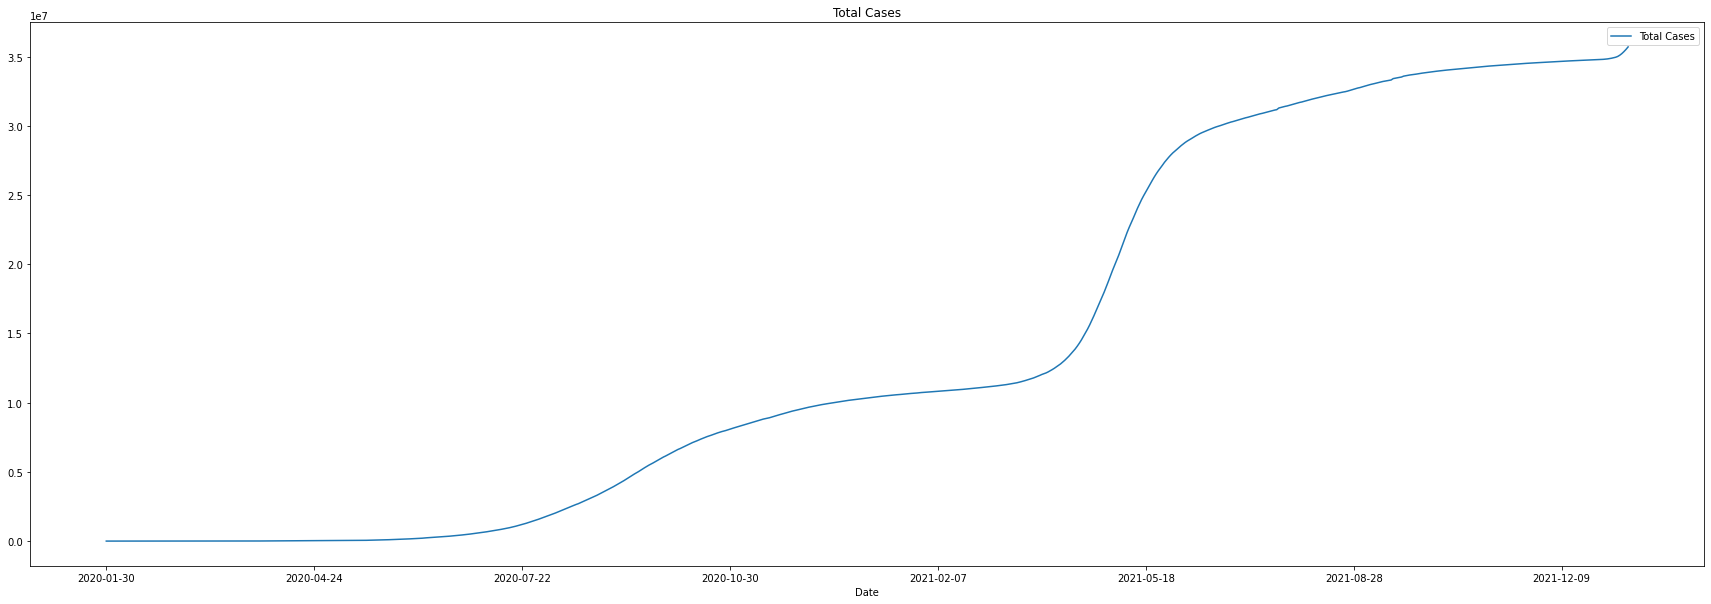

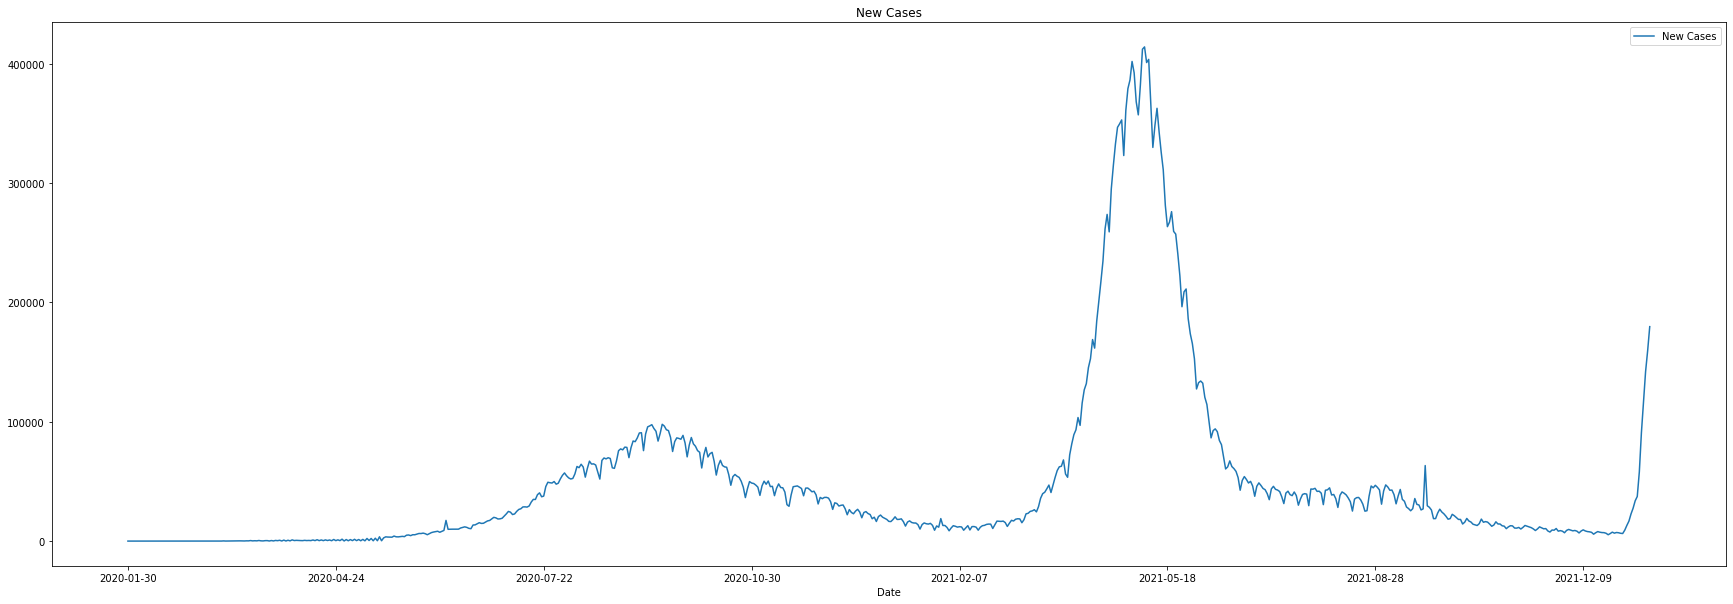

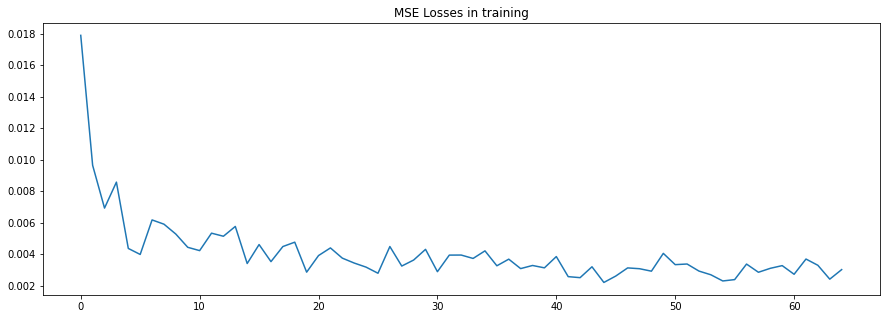

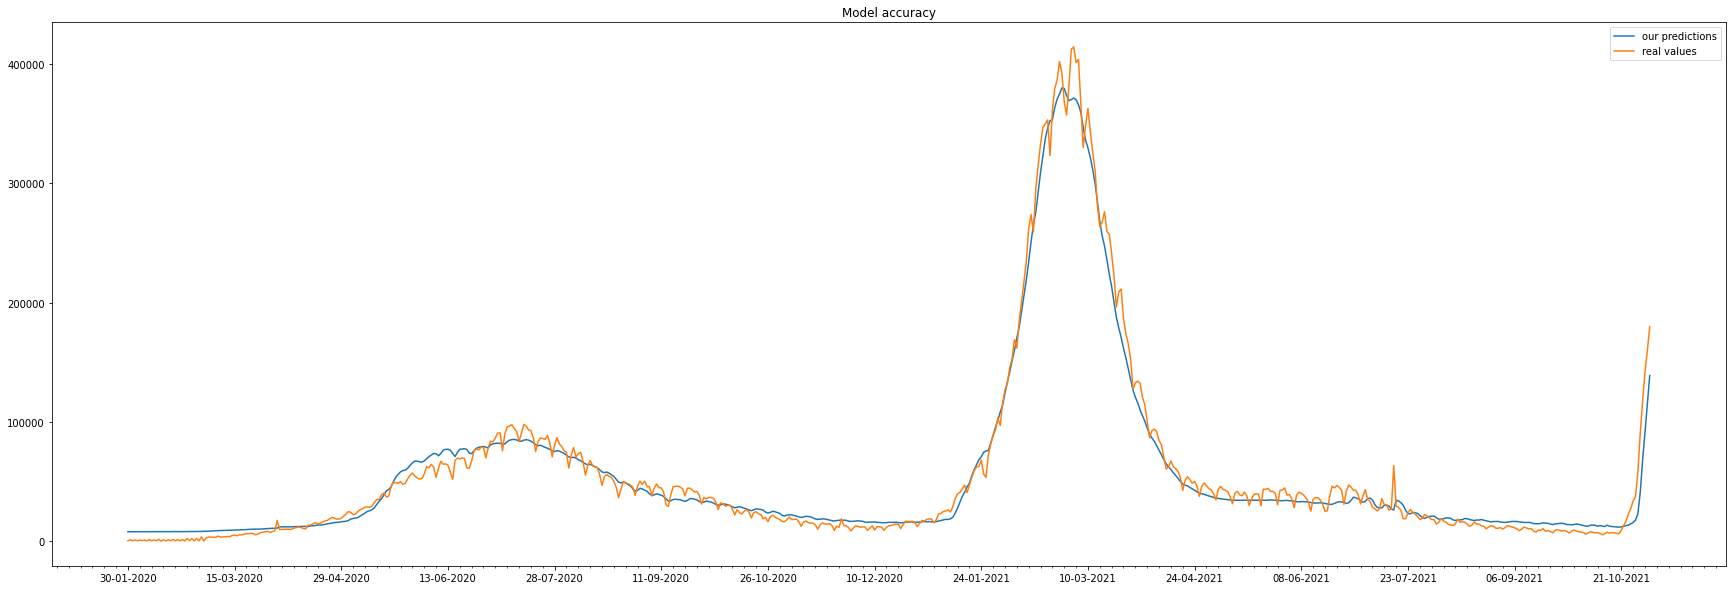

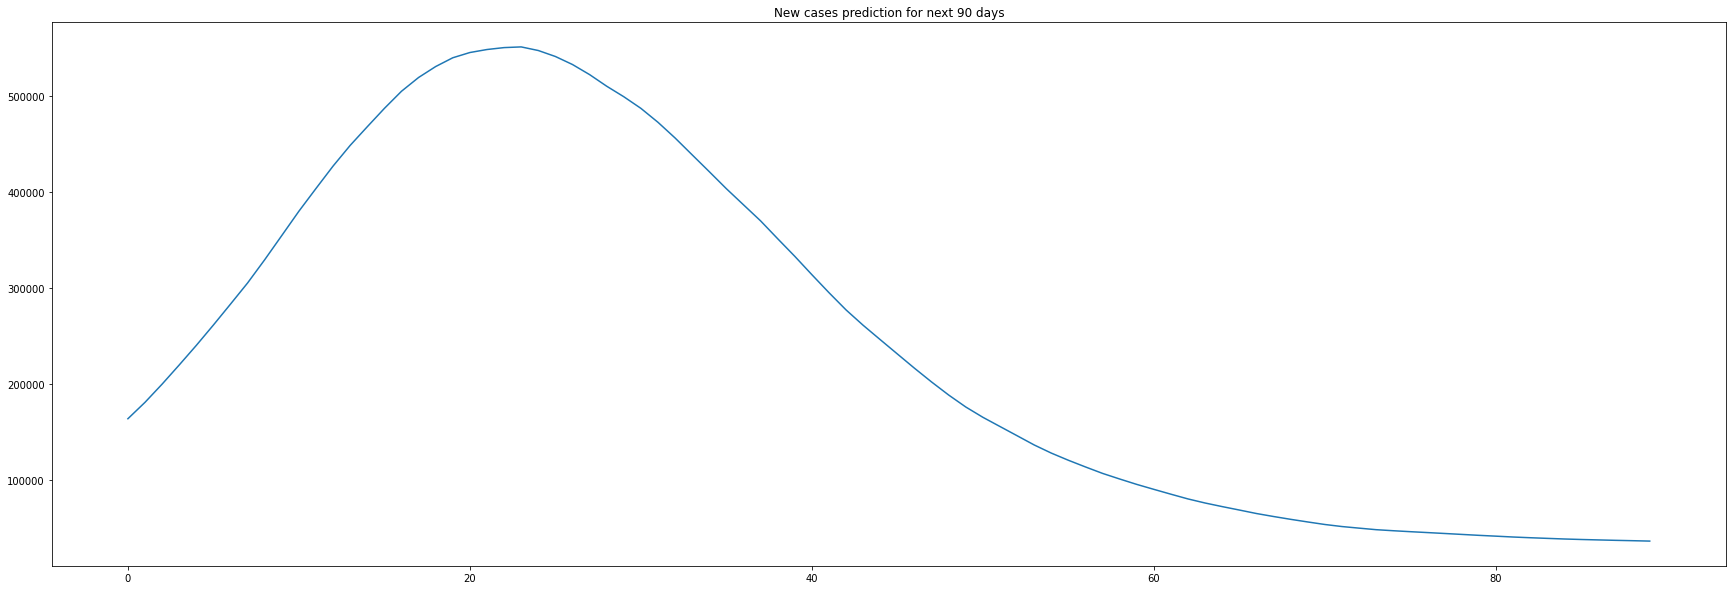

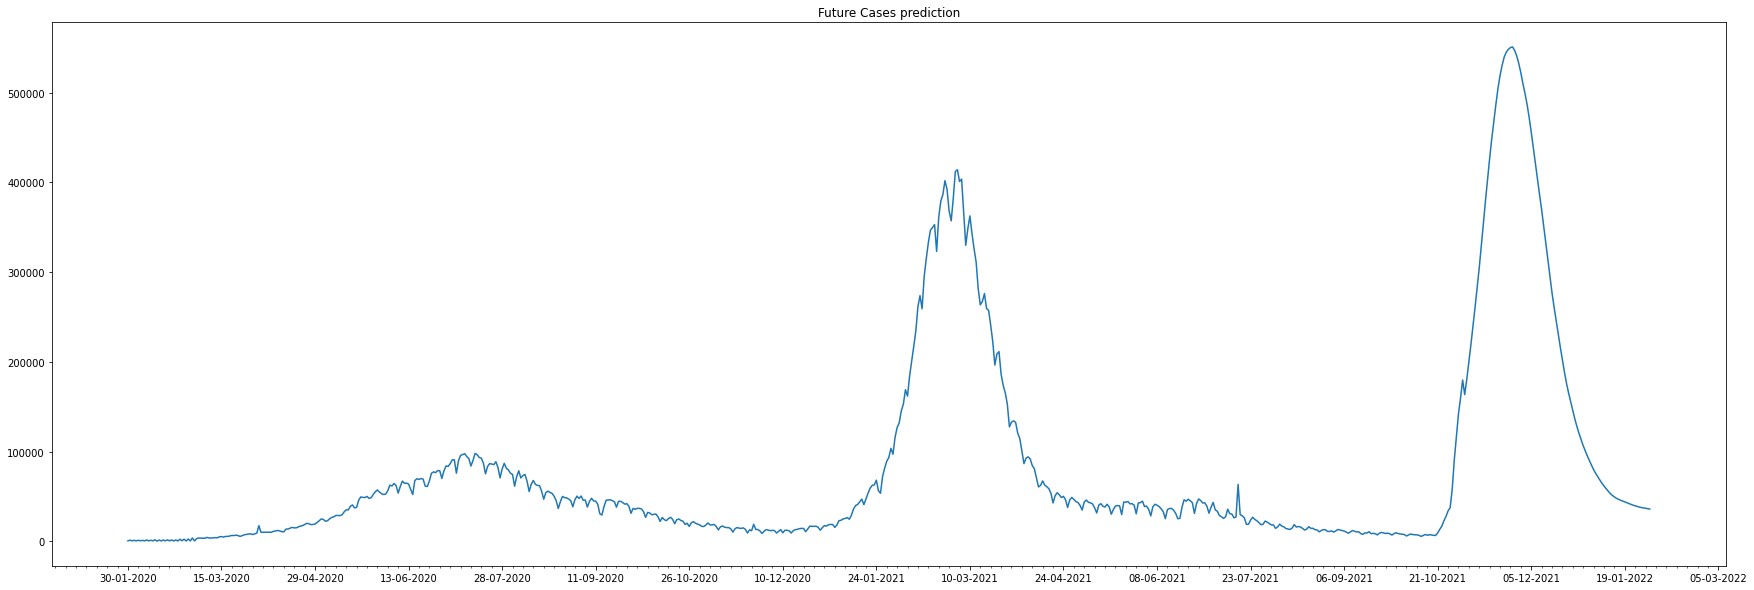

In [31]:
df_new, df_total = load_data("before_3rdwave_data.json")
df_new, df_total = clean(df_new, df_total)
plot_data(df_new, df_total)
train_data, train_labels, array = get_labels(df_new)
model = get_model()
model, H = train(model, train_data, train_labels)
plot_loss(H)
plot_accuracy(model, train_data, train_labels)
seed, upcoming_days_prediction = predict_future(model, array)
plot_all(train_labels, seed)
get_total_cases(upcoming_days_prediction)

# For predicting 4th Wave(Next Wave)

train_data shape:  (739, 1, 90)
train_labels shape:  (739, 1)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 250)               341000    
                                                                 
 dropout_9 (Dropout)         (None, 250)               0         
                                                                 
 dense_9 (Dense)             (None, 250)               62750     
                                                                 
 dropout_10 (Dropout)        (None, 250)               0         
                                                                 
 dense_10 (Dense)            (None, 90)                22590     
                                                                 
 dropout_11 (Dropout)        (None, 90)                0         
                                                          

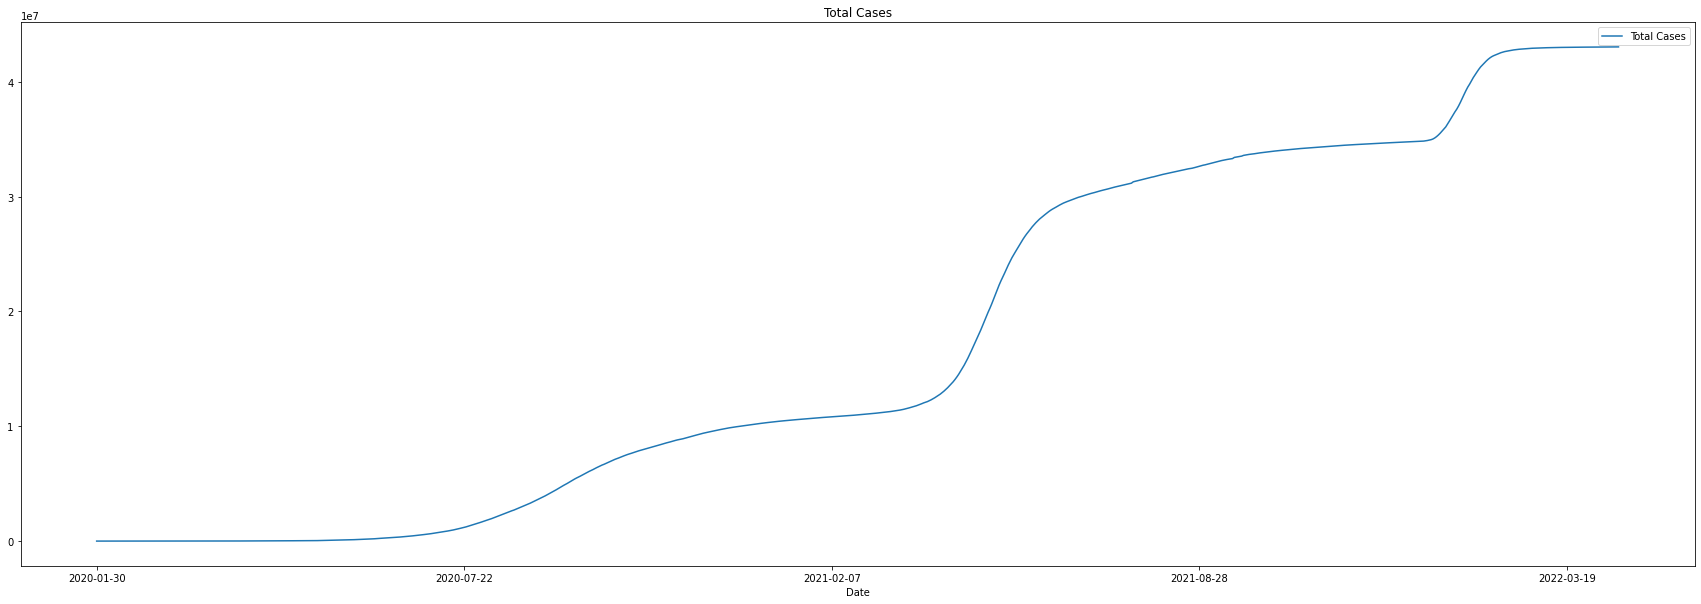

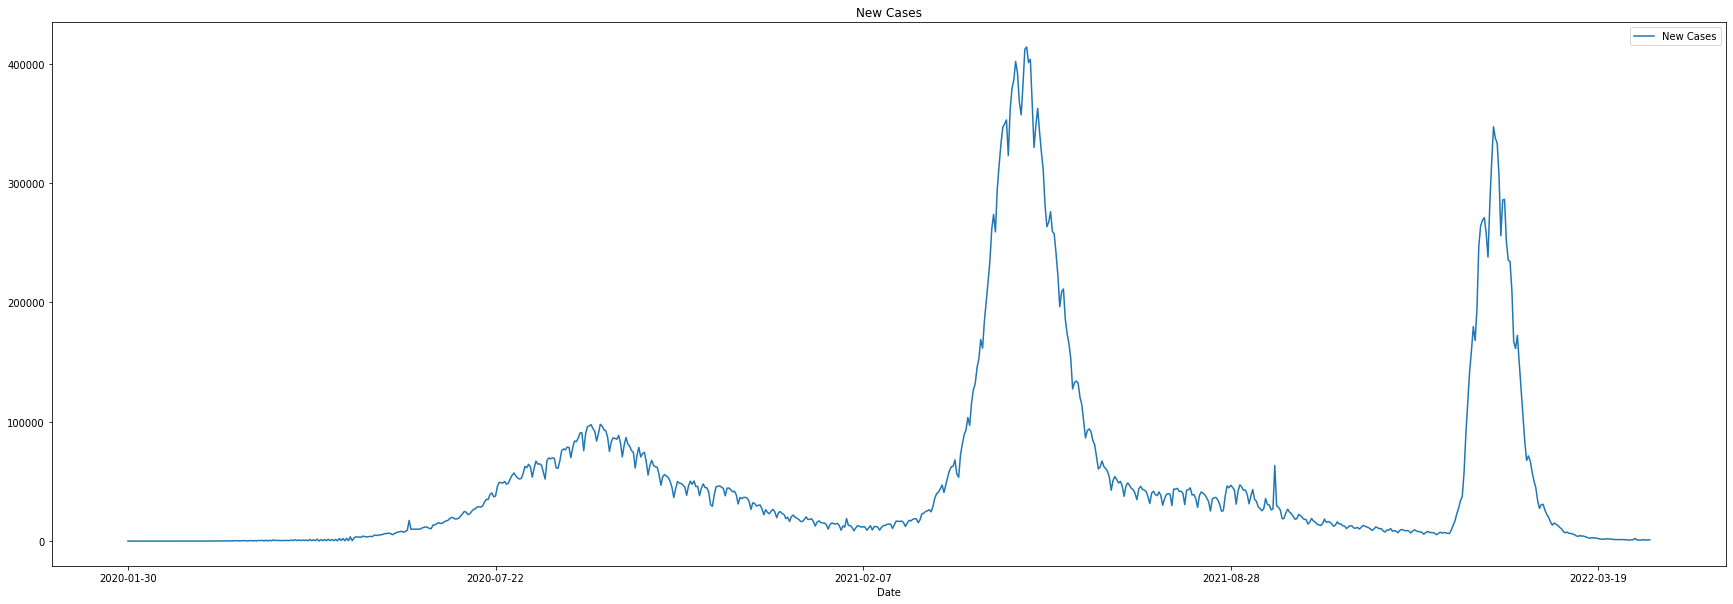

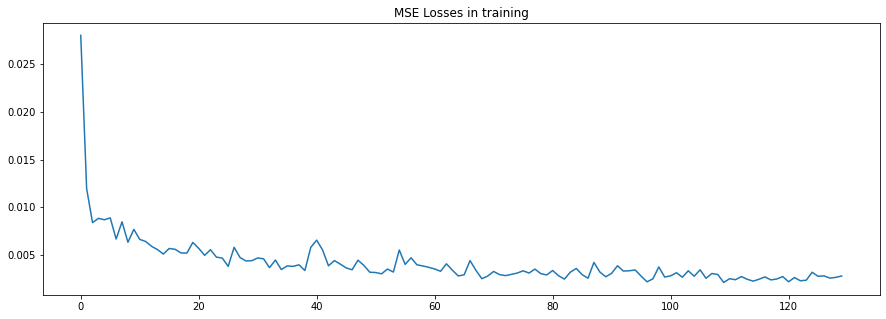

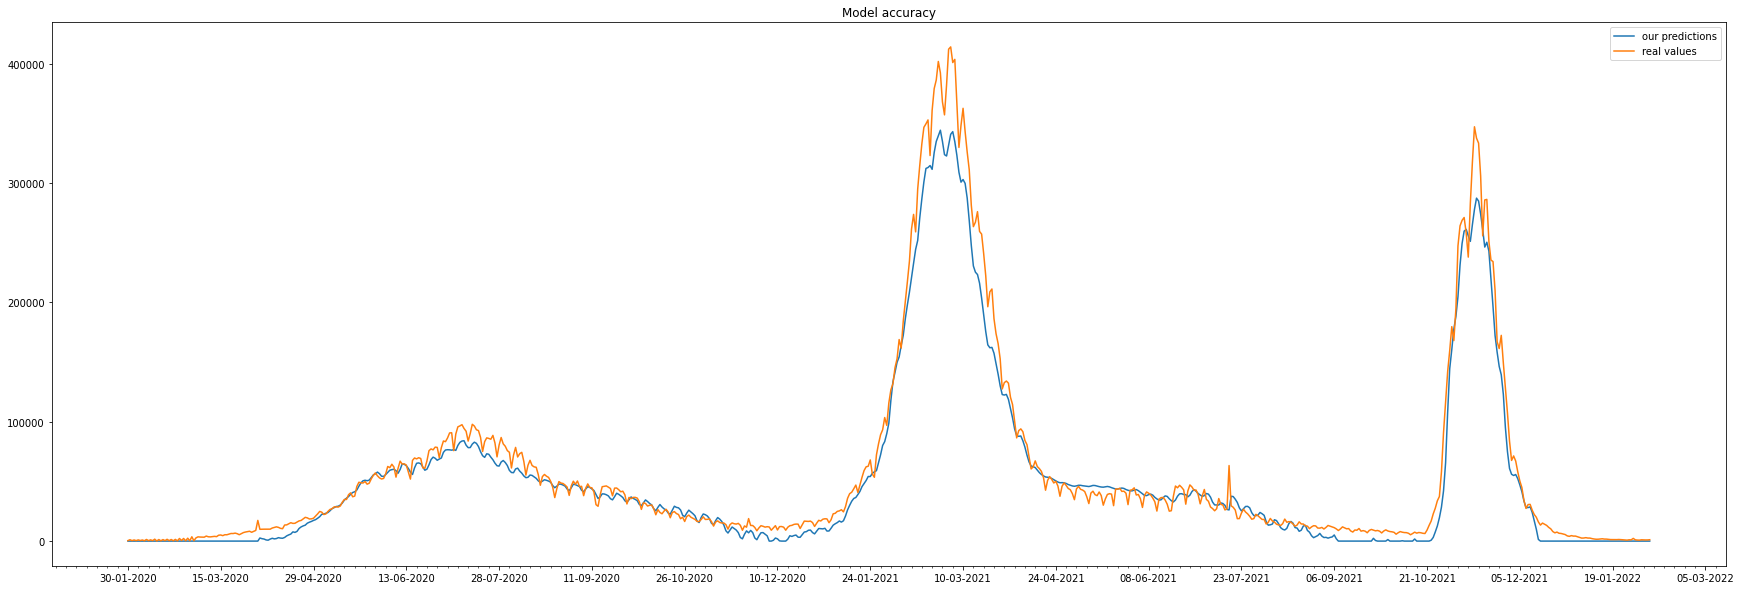

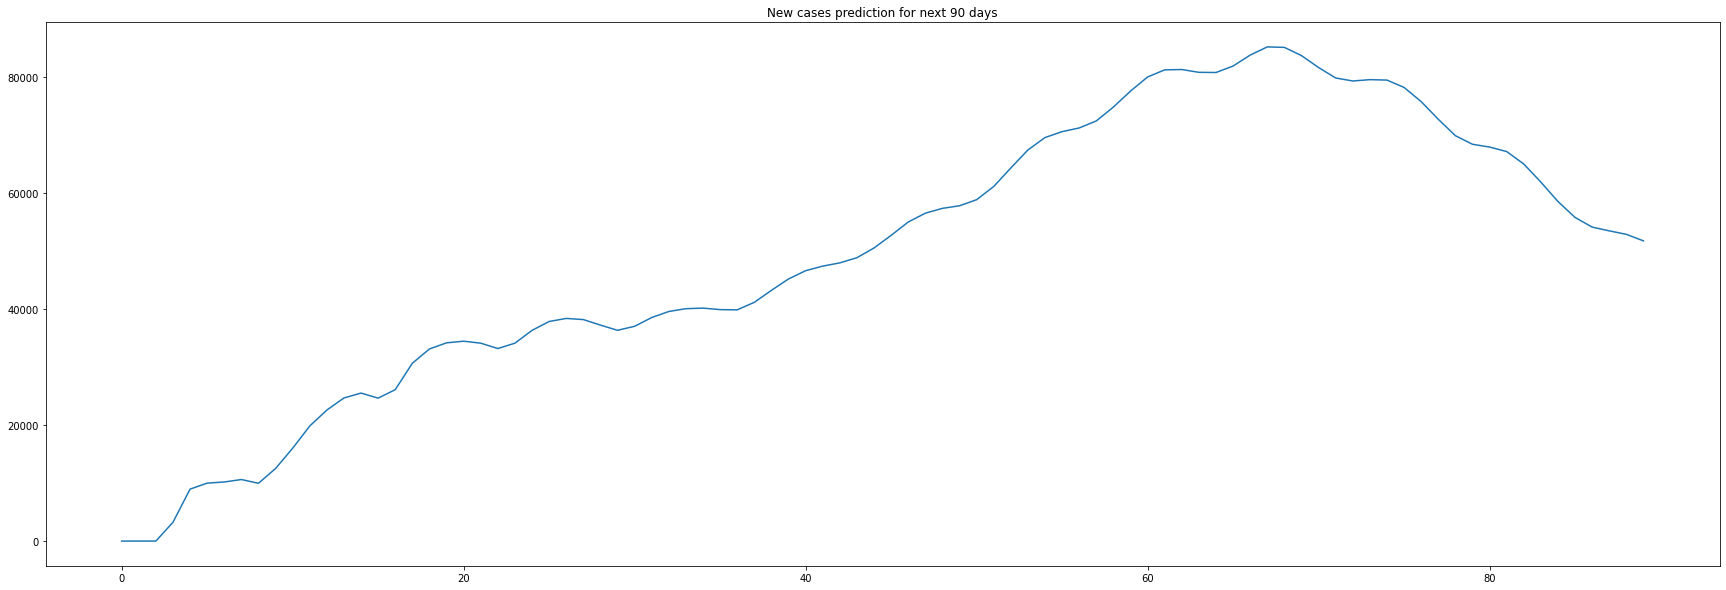

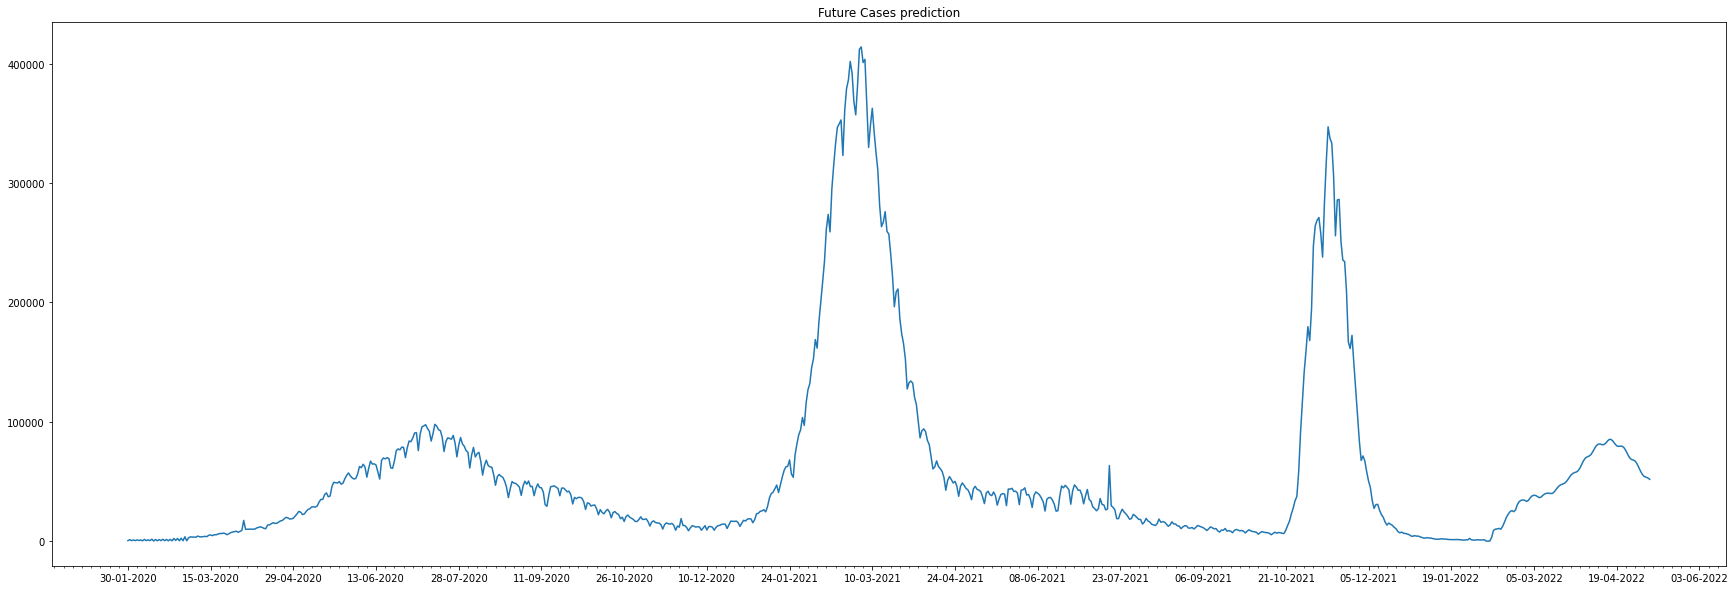

In [32]:
df_new, df_total = load_data("current_data.json")
df_new, df_total = clean(df_new, df_total)
plot_data(df_new, df_total)
train_data, train_labels, array = get_labels(df_new)
model = get_model()
model, H = train(model, train_data, train_labels)
plot_loss(H)
plot_accuracy(model, train_data, train_labels)
seed, upcoming_days_prediction = predict_future(model, array)
plot_all(train_labels, seed)
get_total_cases(upcoming_days_prediction)